In [1]:
import math
import gzip
import pickle
import argparse
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.autograd import Variable
from torch.distributions import Normal

from s2cnn.nn.soft.so3_conv import SO3Convolution
from s2cnn.nn.soft.s2_conv import S2Convolution
from s2cnn.nn.soft.so3_integrate import so3_integrate
from s2cnn.ops.so3_localft import near_identity_grid as so3_near_identity_grid
from s2cnn.ops.s2_localft import near_identity_grid as s2_near_identity_grid

import matplotlib.pyplot as plt

from pytorch_util import load_mnist_data, n2p
from vae import *

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--gpu', '-g', type=int, default=0, help='')
parser.add_argument('--epochs', '-e', type=int, default=10, help='')
parser.add_argument('--batch_dim', '-bd', type=int, default=32, help='')
parser.add_argument('--learning_rate', '-lr', type=float, default=1e-3, help='')

FLAGS, unparsed = parser.parse_known_args()

In [3]:
train_loader, test_loader, train_dataset, _ = load_mnist_data('../mnist_example/s2_mnist.gz', FLAGS.batch_dim)
torch.cuda.set_device(FLAGS.gpu)

In [523]:
z_dims=[10, 9]
encoder_f=[1, 10, 10]
decoder_f=[10, 10, 1]
encoder_b=[30, 20, 6]
decoder_b=[5, 15, 30]
latents = ['gaussian', 'so3']
callbacks = [{'type':'invariant',
           'mlp_h': [100]},
          {'type':'equivariant', 
           'f_list':[1],
           'b_list':[6], 
           'mlp_h': [100]}]
decoder_mlp_h=[100]

vae = NS2VAE(z_dims=z_dims,
             encoder_f=encoder_f,
             decoder_f=decoder_f,
             encoder_b=encoder_b,
             decoder_b=decoder_b,
             latents = latents,
             callbacks = callbacks,
             decoder_mlp_h=decoder_mlp_h,
             max_pooling=True)
print("#params", sum([x.numel() for x in vae.parameters()]))

if torch.cuda.is_available():
    vae.cuda(FLAGS.gpu)

optimizer = torch.optim.Adam(vae.parameters(), lr=FLAGS.learning_rate)

#params 1205041


In [719]:
for epoch in range(FLAGS.epochs):
    print ('\nepoch: %d/%d' % (epoch+1, FLAGS.epochs))
    ave_epoch_loss = []
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)/255
        labels = Variable(labels)

        if torch.cuda.is_available():
            images = images.cuda(FLAGS.gpu)
            labels = labels.cuda(FLAGS.gpu)
        
        rec, kl = vae.elbo(images, n=1)
        kl_w = 1.#float(np.minimum(0., i / (len(train_dataset) / FLAGS.batch_dim)))
        elbo = rec.mean() + kl_w * kl.mean()
        ave_epoch_loss.append(rec.cpu().data.numpy().mean())
        elbo.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        print('\r it: %d/%d \t rec: %4.3f \t kl: %4.3f' % 
              (i, int(len(train_dataset) / FLAGS.batch_dim), \
               rec.cpu().data.numpy().mean(), kl.cpu().data.numpy().mean()), end='')
        
        
    print ('\r ave elbo: %4.3f' % (np.asarray(ave_epoch_loss).mean()), end='')


epoch: 1/10
 it: 33/1718 	 rec: 402.385 	 kl: 8.961

KeyboardInterrupt: 

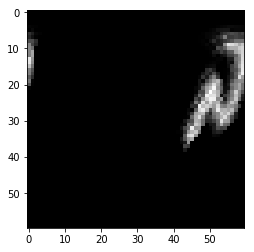

torch.Size([1, 32, 1, 60, 60])


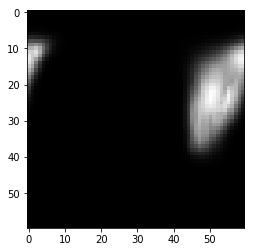

In [741]:
b = 16
idx = np.random.randint(0,b)
plt.imshow(images[idx,0].cpu().data.numpy(), cmap="gray")
plt.show()
print (vae(images).size())
plt.imshow(F.sigmoid(vae(images)[0, idx, 0,]).cpu().data.numpy(), cmap="gray")
plt.show()

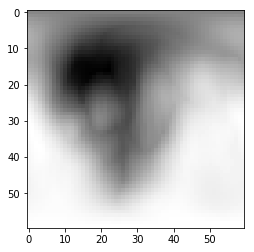

In [598]:
c = np.random.normal(0,1,(1, b ,19))
z = vae.decode(n2p(c).cuda())
idx = np.random.randint(0,16)
plt.imshow(z[0,idx,0].cpu().data.numpy(), cmap="gray")
plt.show()

In [15]:
vae.log_likelihood(images.cuda(FLAGS.gpu), n=2)

Variable containing:
-451.1691
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [560]:
c0 = np.random.normal(0,1,(1, 1, 10))
z1 = n2p(c0)
z1.size()
c1 = np.random.normal(0,1,(1, 1, 3))

torch.Size([1, 1, 1, 60, 60])


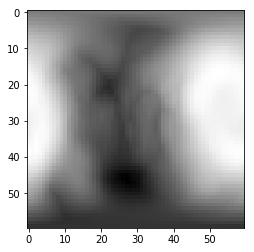

In [597]:
c1 = c1 + np.random.normal(0,0.3,(1, 1, 3))
z2 = SO3reparameterize._expmap_rodrigues(n2p(c1))
z2.size()

# c2 = np.random.normal(0,1,(1, 1, 3))
# z2 = SO3reparameterize._expmap_rodrigues(n2p(c2))
# z2.size()

z = torch.cat([z1, z2.view(*z2.size()[:-2], -1)],-1)
z.size()
s = vae.decode(z.cuda())
print(s.size())
plt.imshow(s[0,0,0].cpu().data.numpy(), cmap="gray")